In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from datasets import load_dataset,Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    pipeline
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, PeftConfig
from bitsandbytes.optim import Adam8bit
import matplotlib.pyplot as plt
from bert_score import score
from sentence_transformers import SentenceTransformer, util
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.llms import HuggingFacePipeline
from langchain_core.documents import Document
import torch
import jieba
import gc
import evaluate
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import ContextualCompressionRetriever, EnsembleRetriever
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import numpy as np
from rouge_score import rouge_scorer
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from concurrent.futures import ThreadPoolExecutor, as_completed

/home/ubuntu/miniconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-26 13:56:12.493872: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/miniconda3/envs/llm/lib/python3.10/site-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
MAX_LEN = 1024

# 数据集处理
def preprocess_example(ex):
    questions = ex.get("questions", [])
    if isinstance(questions, list) and len(questions) > 0:
        if isinstance(questions[0], list):
            question = " ".join([q[0].strip() if len(q) > 0 else "" for q in questions]).strip()
        else:
            question = questions[0].strip()
    else:
        question = str(questions).strip()

    answers = ex.get("answers", [])
    if isinstance(answers, list) and len(answers) > 0:
        if isinstance(answers[0], list):
            answers = " ".join([a[0].strip() if len(a) > 0 else "" for a in answers]).strip()
        else:
            answers = str(answers[0]).strip()
    else:
        answers = str(answers).strip()

    if not answers:
        return None

    return {"input": question, "output": answers}


def tokenize_function(ex, tokenizer, max_len=MAX_LEN):
    inp = ex["input"].strip()
    out = ex["output"].strip()
    eos = tokenizer.eos_token
    text = inp + eos + out + eos
    tok = tokenizer(text, truncation=True, max_length=max_len)

    inp_tok = tokenizer(inp + eos, truncation=True, max_length=max_len)
    labels = [-100] * len(tok["input_ids"])
    labels[len(inp_tok["input_ids"]):] = tok["input_ids"][len(inp_tok["input_ids"]):]
    tok["labels"] = labels
    return tok

In [4]:
# 加载模型，做QLoRA, 4bit量化 模型需要换成8B
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",              
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16 
)

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-8B",
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.to(device)
model.gradient_checkpointing_enable()
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()


Loading checkpoint shards: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


trainable params: 7,667,712 || all params: 8,198,403,072 || trainable%: 0.0935


In [5]:
#加载训练集和验证集
ds_train = load_dataset("FreedomIntelligence/huatuo_encyclopedia_qa", split="train")
ds_val = load_dataset("FreedomIntelligence/huatuo_encyclopedia_qa", split="validation")

ds_train = ds_train.map(preprocess_example, remove_columns=ds_train.column_names)
ds_val = ds_val.map(preprocess_example, remove_columns=ds_val.column_names)

ds_train = ds_train.filter(lambda x: x is not None)
ds_val = ds_val.filter(lambda x: x is not None)

#做测试，所以只取了一部分，需要更改
ds_train = ds_train.shuffle(seed=42).select(range(10000))
ds_val = ds_val.shuffle(seed=42).select(range(1000))

ds_train = ds_train.map(lambda x: tokenize_function(x, tokenizer), remove_columns=["input", "output"])
ds_val = ds_val.map(lambda x: tokenize_function(x, tokenizer), remove_columns=["input", "output"])

In [7]:
def collate_fn(batch):
    input_ids = [torch.tensor(x["input_ids"]) for x in batch]
    labels = [torch.tensor(x["labels"]) for x in batch]
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    return {"input_ids": input_ids, "labels": labels}

In [7]:
#模型训练
training_args = TrainingArguments(
    output_dir="./output/qwen3-8b-sft-huatuo",
    per_device_train_batch_size=1, #随着显存增大可以适当增大
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    fp16=True,
    logging_steps=5,
    eval_strategy="no", 
    save_strategy="steps",
    save_steps=600,
    save_total_limit=2,
    gradient_checkpointing=True,
    report_to="none"
)
optimizer = Adam8bit(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    data_collator=collate_fn,
    optimizers=(optimizer, None)
)

trainer.train()
trainer.save_model("./output/qwen3-8b-sft-huatuo")

Step,Training Loss
5,2.677700
10,2.798600
15,2.778000
20,2.750100
25,2.617400
30,2.595700
35,2.550300
40,2.498100
45,2.433600
50,2.534200


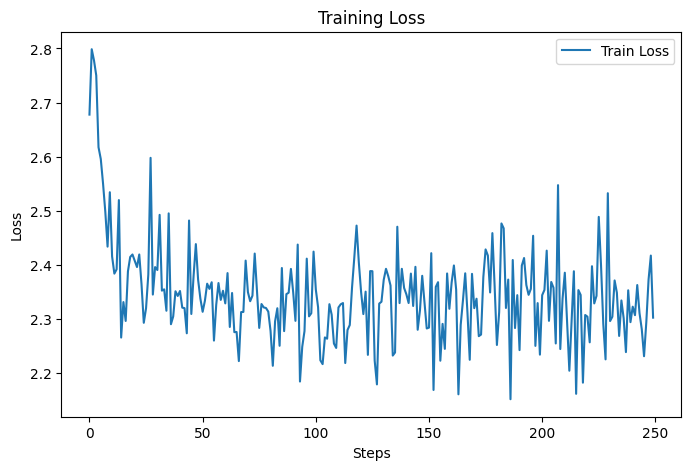

In [8]:
#画出训练集和验证集的损失函数曲线,目前效果不好,因为微调记录的步数太小了
train_losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B", trust_remote_code=True, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token
#加载测试集合,也只取了很小部分
ds_test = load_dataset("FreedomIntelligence/huatuo_encyclopedia_qa", split="test")
ds_test = ds_test.map(preprocess_example, remove_columns=ds_test.column_names)
ds_test = ds_test.filter(lambda x: x is not None)
ds_test = ds_test.shuffle(seed=100).select(range(400))
ds_test = ds_test.map(lambda x: tokenize_function(x, tokenizer), remove_columns=["input", "output"])

In [5]:
inputs = [x['input_ids'] for x in ds_test]
references = [x['labels'] for x in ds_test] 
questions = [] 
questions_text = [] #测试集中的问题
references_text = [] #答案
for i in range(len(ds_test)):
    label_ids = [id for id in references[i] if id != -100]
    references_text.append(tokenizer.decode(label_ids, skip_special_tokens=True))
    question = []
    for j,id in enumerate(references[i]):
        if id == -100:
            question.append(inputs[i][j])
    questions.append(question)
    questions_text.append(tokenizer.decode(question, skip_special_tokens=True))

In [6]:
def eval_generation(preds, refs, lang="zh", use_bleurt=True):
    assert len(preds) == len(refs)

    # 1️⃣ BERTScore（语义贴近度）
    bertscore = evaluate.load("bertscore")
    bs = bertscore.compute(predictions=preds, references=refs, lang=lang)
    bs_f1 = float(np.mean(bs["f1"]))

    # 2️⃣ BLEURT（语义自然度 / 拟人性）
    bleurt_score = None
    if use_bleurt:
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        try:
            import tensorflow as tf
            try:
                tf.config.set_visible_devices([], 'GPU')
            except Exception:
                pass
        except Exception:
            pass

        bleurt = evaluate.load("bleurt", config_name="BLEURT-20")
        bl = bleurt.compute(predictions=preds, references=refs)
        bleurt_score = float(np.mean(bl["scores"]))

    final_score = 0.6 * bs_f1 + 0.4 * ((bleurt_score + 1) / 2)
    return {
        "BERTScore_F1": bs_f1,
        "BLEURT": bleurt_score,
        "Final_Score": final_score
    }

In [7]:
def collate_fn_leftpad(batch):
    # batch 是一批 token id 列表
    batch = [torch.tensor(x, dtype=torch.long) for x in batch]
    max_len = max(len(x) for x in batch)
    pad_id = tokenizer.pad_token_id
    # ✅ 左侧 padding
    padded = torch.stack([
        torch.cat([torch.full((max_len - len(x),), pad_id, dtype=torch.long), x])
        for x in batch
    ])
    attention_mask = (padded != pad_id).long()
    return padded, attention_mask

In [8]:
peft_path = "./output/qwen3-8b-sft-huatuo"

# 1️⃣ 加载 PEFT 配置
config = PeftConfig.from_pretrained(peft_path)

# 2️⃣ 量化配置 (QLoRA 核心)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,               # ✅ QLoRA 启用
    bnb_4bit_quant_type="nf4",       # 推荐 nf4 精度更高
    bnb_4bit_use_double_quant=True,  # 双量化减少误差
    bnb_4bit_compute_dtype=torch.float16  # 半精度计算
)

# 3️⃣ 加载 Tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path, trust_remote_code=True)
# ✅ 强制左填充
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


# 4️⃣ 加载量化基础模型
base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    quantization_config=bnb_config,  # ✅ 使用 QLoRA 量化配置
    device_map="auto",               # 自动分配 GPU/CPU
    trust_remote_code=True
)
base_model.config.pad_token_id = tokenizer.pad_token_id
# 5️⃣ 加载 LoRA 微调权重
model_finetune = PeftModel.from_pretrained(base_model, peft_path)

Loading checkpoint shards: 100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


In [9]:
# 模型生成答案
model_finetune.eval()
BATCH_SIZE = 16
dataloader = DataLoader(questions, batch_size=BATCH_SIZE, collate_fn=collate_fn_leftpad)
model_finetune.config.pad_token_id = tokenizer.pad_token_id
model_finetune.base_model.config.pad_token_id = tokenizer.pad_token_id

predictions_text = []
model_finetune.config.use_cache = True
for batch, attention_mask in tqdm(dataloader, desc="Generating"):
    batch = batch.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_finetune.generate(
            input_ids=batch,
            attention_mask=attention_mask,
            max_new_tokens=512,
            do_sample=False,
            num_beams=1,
            temperature=1.0,
            use_cache=True
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions_text.extend(decoded)

torch.cuda.empty_cache()

Generating: 100%|██████████| 25/25 [41:44<00:00, 100.18s/it]


In [12]:
results = eval_generation(predictions_text, references_text, lang="zh", use_bleurt=True)

Computing checksums: 100%|██████████| 1/1 [00:06<00:00,  6.64s/it]

INFO:tensorflow:Reading checkpoint /home/ubuntu/.cache/huggingface/metrics/bleurt/BLEURT-20/downloads/extracted/1c6e4d247aa8e80e95fc3d9b17021e14a678d8910e6d2269cd50e51561bf5be2/BLEURT-20.



INFO:tensorflow:Reading checkpoint /home/ubuntu/.cache/huggingface/metrics/bleurt/BLEURT-20/downloads/extracted/1c6e4d247aa8e80e95fc3d9b17021e14a678d8910e6d2269cd50e51561bf5be2/BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: /home/ubuntu/.cache/huggingface/metrics/bleurt/BLEURT-20/downloads/extracted/1c6e4d247aa8e80e95fc3d9b17021e14a678d8910e6d2269cd50e51561bf5be2/BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: /home/ubuntu/.cache/huggingface/metrics/bleurt/BLEURT-20/downloads/extracted/1c6e4d247aa8e80e95fc3d9b17021e14a678d8910e6d2269cd50e51561bf5be2/BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [13]:
print("fine-tune")
print(f"BERTScore_F1: {results['BERTScore_F1']:.4f}")
print(f"BLEURT: {results['BLEURT']:.4f}")
print(f"Final Score: {results['Final_Score']:.4f}")

fine-tune
BERTScore_F1: 0.6406
BLEURT: 0.4526
Final Score: 0.6749


In [8]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",              
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16 
)

model_original = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-8B",
    quantization_config=bnb_config,
    trust_remote_code=True
)
model_original.to(device)
model_original.gradient_checkpointing_enable()
model_original.config.use_cache = False
model_original = prepare_model_for_kbit_training(model_original)

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model_original = get_peft_model(model_original, lora_cfg)

Loading checkpoint shards: 100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


In [9]:
# 加载未微调的模型 
model_original.eval()
predictions_text_original = []
model_original.config.pad_token_id = tokenizer.pad_token_id
model_original.base_model.config.pad_token_id = tokenizer.pad_token_id
BATCH_SIZE = 16

dataloader = DataLoader(questions, batch_size=BATCH_SIZE, collate_fn=collate_fn_leftpad)

predictions_text_original = []

for batch, attention_mask in tqdm(dataloader, desc="Generating (original model)"):
    batch = batch.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_original.generate(
            input_ids=batch,
            attention_mask=attention_mask,
            max_new_tokens=512,
            do_sample=False,
            num_beams=1,
            temperature=1.0,
            use_cache=True
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions_text_original.extend(decoded)

torch.cuda.empty_cache()

Generating (original model): 100%|██████████| 25/25 [43:51<00:00, 105.26s/it]


In [10]:
results_original = eval_generation(predictions_text_original, references_text, lang="zh", use_bleurt=True)

Computing checksums: 100%|██████████| 1/1 [00:06<00:00,  6.65s/it]

INFO:tensorflow:Reading checkpoint /home/ubuntu/.cache/huggingface/metrics/bleurt/BLEURT-20/downloads/extracted/1c6e4d247aa8e80e95fc3d9b17021e14a678d8910e6d2269cd50e51561bf5be2/BLEURT-20.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint BLEURT-20
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:BLEURT-20
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:... vocab_file:None
INFO:tensorflow:... do_lower_case:None
INFO:tensorflow:... sp_model:sent_piece
INFO:tensorflow:... dynamic_seq_length:True
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Will load model: /home/ubuntu/.cache/huggingface/metrics/bleurt/BLEURT-20/downloads/extracted/1c6e4d247aa8e80e95fc3d9b17021e14a678d8910e6d2269cd50e51561bf5be2/BLEURT-20/sent_piece.model.
INFO:tensorflow:SentencePiec

INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [11]:
print("baseline")
print(f"BERTScore_F1: {results_original['BERTScore_F1']:.4f}")
print(f"BLEURT: {results_original['BLEURT']:.4f}")
print(f"Final Score: {results_original['Final_Score']:.4f}")

baseline
BERTScore_F1: 0.6335
BLEURT: 0.4656
Final Score: 0.6732


In [7]:
# 做RAG
# 加载医学数据集

ds = load_dataset("FreedomIntelligence/Huatuo26M-Lite", split="train")

docs = []
load_dict = {}
load_docs = []
for i, record in enumerate(ds):
    q = record.get("question", "")
    a = record.get("answer", "")
    if q and a:
        load_dict[a] = q
        content = a
        load_docs.append(content)
        docs.append(Document(page_content=content))
    if i >= 5000:  # 只取前5000条
        break

print(f"Loaded {len(docs)} documents.")

Loaded 5001 documents.


In [8]:
# 生成嵌入向量， 存入向量数据库
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-large-zh-v1.5", model_kwargs={"device": "cuda"})
vectorstore = FAISS.from_documents(docs, embedding_model)

/tmp/ipykernel_266591/423491904.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-large-zh-v1.5", model_kwargs={"device": "cuda"})


In [9]:
#混合检索方法BM25+稠密检索
BM25_en_retriever = BM25Retriever.from_texts(load_docs, preprocess_func=lambda text: list(jieba.cut(text)))
BM25_en_retriever.k = 3
BGE_en_vectorstore = vectorstore
BGE_en_retrieverk = BGE_en_vectorstore.as_retriever(search_kwargs={"k": 3})
ensemble_retriever = EnsembleRetriever(retrievers=[BM25_en_retriever, BGE_en_retrieverk],
                                              weights=[0.5, 0.5])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.917 seconds.
Prefix dict has been built successfully.


In [10]:
def eval_one(pair):
    load_text, question = pair
    docs = ensemble_retriever.invoke(question)
    contents = [doc.page_content for doc in docs]
    if load_text in contents:
        pos = contents.index(load_text) + 1
        return (1, 1 / pos)
    return (0, 0)

In [11]:
pairs = list(load_dict.items())
hit_rate, mrr = 0, 0

with ThreadPoolExecutor(max_workers=24) as executor:
    futures = [executor.submit(eval_one, p) for p in pairs]
    for f in tqdm(as_completed(futures), total=len(pairs), desc="Evaluating"):
        hit, reciprocal = f.result()
        hit_rate += hit
        mrr += reciprocal

hit_rate /= len(pairs)
mrr /= len(pairs)

Evaluating:   0%|          | 0/5001 [00:00<?, ?it/s]

KeyboardInterrupt



In [17]:
print(f"Hit Rate: {hit_rate:.4f}")
print(f"MRR: {mrr:.4f}")

Hit Rate: 0.7778
MRR: 0.5396


In [12]:
peft_path = "./output/qwen3-8b-sft-huatuo"

# 1️⃣ 加载 PEFT 配置
config = PeftConfig.from_pretrained(peft_path)

# 2️⃣ 量化配置 (QLoRA 核心)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,               # ✅ QLoRA 启用
    bnb_4bit_quant_type="nf4",       # 推荐 nf4 精度更高
    bnb_4bit_use_double_quant=True,  # 双量化减少误差
    bnb_4bit_compute_dtype=torch.float16  # 半精度计算
)

# 3️⃣ 加载 Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    config.base_model_name_or_path,
    trust_remote_code=True,
    padding_side="left"
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 4️⃣ 加载量化基础模型
base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    quantization_config=bnb_config,  # ✅ 使用 QLoRA 量化配置
    device_map="auto",               # 自动分配 GPU/CPU
    trust_remote_code=True
)

# 5️⃣ 加载 LoRA 微调权重
model_finetune = PeftModel.from_pretrained(base_model, peft_path)
generator = pipeline(
    "text-generation",
    model=model_finetune,
    tokenizer=tokenizer,
    max_new_tokens=512, #生成文本的最大长度,可以调整,当前效果不是很好
    do_sample=True,
    temperature=0.5,
    pad_token_id=tokenizer.pad_token_id,
    device_map="auto"
)

llm = HuggingFacePipeline(pipeline=generator)

Loading checkpoint shards: 100%|██████████| 5/5 [00:40<00:00,  8.17s/it]
Device set to use cuda:0
/tmp/ipykernel_266591/2131622064.py:44: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=generator)


In [15]:
# 提示词工程 少样本提示词+推理链
prompt_template = """
你是一名专业的医学顾问，回答问题时请严格遵循以下步骤：
1. 先思考 (“Thinking”)，对问题的关键因素进行分析。
2. 用逻辑推理逐步得出答案 (Chain-of-Thought)。
3. 给出详细答案，包括原因、机制、常见表现以及可能的注意事项。

示例：
问题：发烧可能由哪些因素引起？
思考：发烧是人体对病原体或异常状态的反应，常见原因包括病毒、细菌感染或免疫反应。不同病因可能伴随不同症状，需要结合临床表现分析。
答案：发烧可能由多种因素引起，包括：
- **病毒感染**：如流感、腮腺炎，常伴有乏力、头痛。
- **细菌感染**：如肺炎、尿路感染，常伴有局部感染症状。
- **免疫反应或炎症**：如自身免疫性疾病，可能伴随关节疼痛、皮疹。
临床上需要结合其他症状和检查来确定具体原因，并注意发热的持续时间和程度。

问题：{question}
参考资料：
{context}
思考：
"""

QA_PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)

# -------------------------
# 3️⃣ 构建 RetrievalQA 链
# -------------------------
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=ensemble_retriever,  # 你的检索器
    chain_type="stuff",
    chain_type_kwargs={"prompt": QA_PROMPT},
    return_source_documents=True
)

In [16]:
# 测试RAG的效果
ds_test = Dataset.from_dict({"question": questions_text})

def generate_batch(batch):
    outputs = generator(batch["question"], max_new_tokens=512, batch_size=8)
    preds = []
    for out in outputs:
        text = out[0]['generated_text']
        if "答案：" in text:
            text = text.split("答案：")[-1].split("问题")[0]
        preds.append(text)
    return {"prediction": preds}

ds_test = ds_test.map(generate_batch, batched=True, batch_size=8)
predictions_text_RAG = ds_test["prediction"]


Map: 100%|██████████| 400/400 [1:25:10<00:00, 12.78s/ examples]


In [17]:
results_RAG = eval_generation(predictions_text_RAG, references_text, lang="zh", use_bleurt=True)

Computing checksums: 100%|██████████| 1/1 [00:06<00:00,  6.63s/it]

INFO:tensorflow:Reading checkpoint /home/ubuntu/.cache/huggingface/metrics/bleurt/BLEURT-20/downloads/extracted/1c6e4d247aa8e80e95fc3d9b17021e14a678d8910e6d2269cd50e51561bf5be2/BLEURT-20.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint BLEURT-20
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:BLEURT-20
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:... vocab_file:None
INFO:tensorflow:... do_lower_case:None
INFO:tensorflow:... sp_model:sent_piece
INFO:tensorflow:... dynamic_seq_length:True
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Will load model: /home/ubuntu/.cache/huggingface/metrics/bleurt/BLEURT-20/downloads/extracted/1c6e4d247aa8e80e95fc3d9b17021e14a678d8910e6d2269cd50e51561bf5be2/BLEURT-20/sent_piece.model.
INFO:tensorflow:SentencePiec

INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [18]:
print("RAG + Prompt")
print(f"BERTScore_F1: {results_RAG['BERTScore_F1']:.4f}")
print(f"BLEURT: {results_RAG['BLEURT']:.4f}")
print(f"Final Score: {results_RAG['Final_Score']:.4f}")

RAG + Prompt
BERTScore_F1: 0.6326
BLEURT: 0.4789
Final Score: 0.6753
